# Dynamic Optimization and Reinforcement Learning
## Project Phase 2: Stock Market Trading
### Georgios Gialouris 2019030063
### Nikolaos Angelidis 2019030190

## Import libraries

In [ ]:
import numpy as np
from itertools import product
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter

## Task 1

### Create the environment for our Q-learning algorithm

In [ ]:
########## Set up the MDP environment ##########
class StockEnvironment:
    def __init__(self, n, markov_chains_pr, stock_gains, transaction_fee):
        self.n = n
        self.markov_chains_pr = markov_chains_pr
        self.stock_gains = stock_gains
        self.transaction_fee = transaction_fee
        self.states = self.get_state_space(self.n)
        self.actions = self.get_action_space(self.n)
        self.trans_pr = self.get_transition_probabilities(self.states, self.markov_chains_pr, self.n)
        self.rewards = self.get_rewards(self.states, self.stock_gains, self.transaction_fee, self.n)

    def get_state_space(self, n):
        combinations = list(product('HL', repeat=n))  # Generate all combinations of 'H' and 'L' of length n (number of stocks) with repetitions
        combinations = [''.join(comb) for comb in combinations]  # Convert tuples to strings
        # Prepend each combination with the numbers from 1 to n
        states = []
        for i in range(1, n + 1):
            for comb in combinations:
                states.append(f"{i}{comb}")
        return states

    def get_action_space(self, n):
        actions = list(range(1, n + 1))
        return actions

    def get_transition_probabilities(self, states, markov_chains_pr, n):
        # markov_chains_pr is an (n x 4) matrix, where rows represent the stocks and columns represent the probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chains
        num_states = len(states)
        trans_pr = np.zeros((num_states, num_states))
        for i, from_state in enumerate(states):
            for j, to_state in enumerate(states):
                trans_pr[i, j] = 1
                # Convert the state strings to lists of characters excluding the first one (i.e., which stock we are currently holding)
                for k, (from_markov_state, to_markov_state) in enumerate(zip(list(from_state)[-n:], list(to_state)[-n:])):
                    if from_markov_state == 'H' and to_markov_state == 'H':
                        trans_pr[i, j] *= markov_chains_pr[k, 0]  ## pHH
                    elif from_markov_state == 'H' and to_markov_state == 'L':
                        trans_pr[i, j] *= markov_chains_pr[k, 1]  ## pHL
                    elif from_markov_state == 'L' and to_markov_state == 'H':
                        trans_pr[i, j] *= markov_chains_pr[k, 2]  ## pLH
                    elif from_markov_state == 'L' and to_markov_state == 'L':
                        trans_pr[i, j] *= markov_chains_pr[k, 3]  ## pLL
        return trans_pr

    def get_rewards(self, states, stock_gains, transaction_fee, n):
        # stock_gains is an (n x 2) matrix, where rows represent the stocks and columns represent the expected gains (rH, rL) of each stock depending on the state (H, L) of the Markov chain
        num_states = len(states)
        rewards = np.zeros((num_states, num_states))
        for i, from_state in enumerate(states):
            for j, to_state in enumerate(states):
                # Convert the state strings to lists of characters
                from_state_chars = list(from_state)
                to_state_chars = list(to_state)
                old_stock = int(from_state[:-n])
                new_stock = int(to_state[:-n])
                if new_stock == old_stock:  # Invest in the same stock
                    if to_state_chars[new_stock] == 'H':
                        rewards[i, j] = stock_gains[new_stock - 1, 0]  # rH
                    elif to_state_chars[new_stock] == 'L':
                        rewards[i, j] = stock_gains[new_stock - 1, 1]  # rL
                else:  # Switch stocks
                    if to_state_chars[new_stock] == 'H':
                        rewards[i, j] = stock_gains[new_stock - 1, 0] - transaction_fee  # rH - transaction_fee
                    elif to_state_chars[new_stock] == 'L':
                        rewards[i, j] = stock_gains[new_stock - 1, 1] - transaction_fee  # rL - transaction_fee
        return rewards


### Q learning algorithm implementation

In [ ]:
# Implement the Q-learning algorithm
def q_learning(states, actions, trans_pr, rewards, gamma, initial_epsilon, initial_alpha, min_epsilon, min_alpha, episodes, episode_length):
    # Measurements
    reward_per_episode = np.zeros(episodes)
    epsilon_vals = np.zeros(episodes)
    alpha_vals = np.zeros(episodes)
    mean_rewards = np.zeros(episodes)
    epsilon_decay = 0.999  # Epsilon decay per episode
    alpha_decay = 0.001  # Alpha decay per episode
    epsilon = initial_epsilon
    alpha = initial_alpha

    # Initialize Q-table
    q_table = np.zeros((len(states), len(actions)))  # Initialize the Q-table

    state_indices = {state: idx for idx, state in enumerate(states)}  # Map states to indices
    possible_next_states = {action: [i for i, k in enumerate(states) if k.startswith(str(action))] for action in actions}  # List of possible next states (i.e., states whose first character corresponds to the chosen action)

    progress_bar = tqdm(range(episodes))
    for episode in progress_bar:
        state = random.choices(states, k=1)[0]  # Select a random state
        total_episode_reward = 0
        episode_rewards = []

        for _ in range(episode_length):
            # Get state index
            state_idx = state_indices[state]

            # Get action with epsilon-greedy (Explore/Exploit)
            action = random.choices([random.choices(actions, k=1)[0], np.argmax(q_table[state_idx]) + 1], weights=[epsilon, 1 - epsilon], k=1)[0]

            # Get next state and reward
            pr_next_states = trans_pr[state_idx, possible_next_states[action]]
            next_state_idx = random.choices(possible_next_states[action], weights=pr_next_states, k=1)[0]
            reward = rewards[state_idx, next_state_idx]

            # Update Q-table
            q_table[state_idx, action - 1] += alpha * (reward + gamma * np.max(q_table[next_state_idx]) - q_table[state_idx, action - 1])

            # Move to the next state
            state = states[next_state_idx]
            total_episode_reward += reward
            episode_rewards.append(reward)

        epsilon_vals[episode] = epsilon
        alpha_vals[episode] = alpha
        reward_per_episode[episode] = total_episode_reward
        mean_rewards[episode] = np.mean(episode_rewards)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        alpha = max(min_alpha, initial_alpha * np.exp(-alpha_decay * episode))

        progress_bar.set_postfix({
        'epsilon' : epsilon,
        'mean reward' : mean_rewards[episode],
        'alpha' : alpha
        })

    policy = {s: (np.argmax(q_table[s_idx]) + 1) for s_idx, s in enumerate(states)}
    return policy, q_table, reward_per_episode, epsilon_vals, alpha_vals, mean_rewards


### Q-learning algorithm for scenario with γ = 0 and N = 2

In [ ]:
# Confirm that our Q-learning algorithm finds the optimal policy given the scenario of the midterm exam
N = 2  # Number of stocks
markov_chains_pr = np.array([[0.5, 0.5, 0.5, 0.5],   # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 1
                             [0.9, 0.1, 0.1, 0.9]])  # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 2
stock_gains = np.array([[0.1, -0.02],                # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                        [0.05, 0.01]])               # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain
transaction_fee = 0.01

gamma = 0               # Discount factor
initial_epsilon = 1     # Exploration rate
initial_alpha = 0.5     # Learning rate
min_epsilon = 0.1       # Minimum exploration rate
min_alpha = 0.001       # Minimum learning rate

episodes = 20000        # Number of episodes
episode_length = 100    # Number of steps per episode

env = StockEnvironment(N, markov_chains_pr, stock_gains, transaction_fee)  # Environment initialization
states = env.states
actions = env.actions
trans_pr = env.trans_pr
rewards = env.rewards

# Implement the Q-learning Algorithm and get the measurements and learned policy and value function
learned_policy, q_table, reward_per_episode, epsilon_vals, alpha_vals, mean_rewards = q_learning(states, actions, trans_pr, rewards, gamma, initial_epsilon, initial_alpha, min_epsilon, min_alpha, episodes, episode_length)
learned_value_function = [np.max(q_table[i]) for i in range(len(states))]

print("State Space:", states)
print("Action Space:", actions)
# print("Transition Probabilities:", trans_pr)
# print("Rewards:", rewards)
print("Q-table", q_table)
print("Learned Policy:", learned_policy)
print("Learned Value Function:", learned_value_function)
print("Optimal Policy: {'1HH': 1, '1HL': 1, '1LH': 1, '1LL': 1, '2HH': 2, '2HL': 1, '2LH': 2, '2LL': 1}")
print("Optimal Value Function: [0.04  0.04  0.04  0.04  0.046 0.03  0.046 0.03 ]")

  0%|          | 0/10000 [00:00<?, ?it/s]

State Space: ['1HH', '1HL', '1LH', '1LL', '2HH', '2HL', '2LH', '2LL']
Action Space: [1, 2]
Q-table [[0.04075464 0.03552086]
 [0.04063754 0.00456065]
 [0.04100044 0.03589217]
 [0.03854547 0.00436559]
 [0.03009588 0.04583123]
 [0.03109311 0.0139154 ]
 [0.03054595 0.04560023]
 [0.03027132 0.01374282]]
Learned Policy: {'1HH': 1, '1HL': 1, '1LH': 1, '1LL': 1, '2HH': 2, '2HL': 1, '2LH': 2, '2LL': 1}
Learned Value Function: [0.04075463938938634, 0.04063754023918082, 0.04100044195132284, 0.038545471207004724, 0.04583123221188809, 0.0310931108201974, 0.04560022802059318, 0.03027131911863368]
Optimal Policy: {'1HH': 1, '1HL': 1, '1LH': 1, '1LL': 1, '2HH': 2, '2HL': 1, '2LH': 2, '2LL': 1}
Optimal Value Function: [0.04  0.04  0.04  0.04  0.046 0.03  0.046 0.03 ]


### Plotting the result of our algorithm

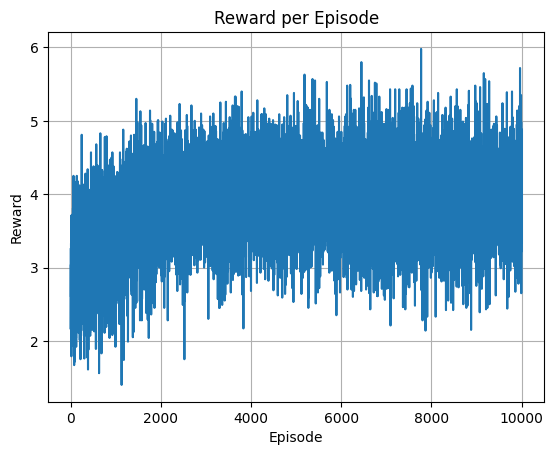

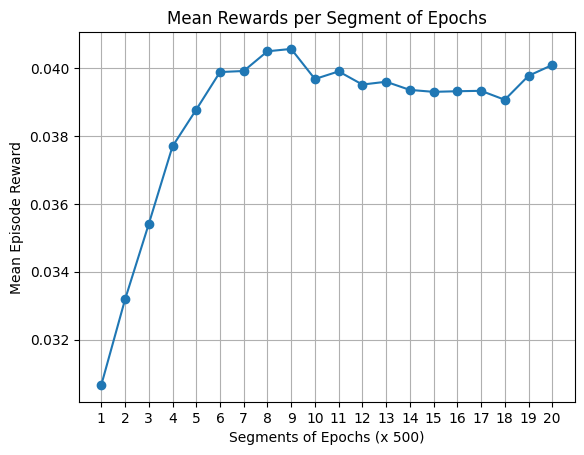

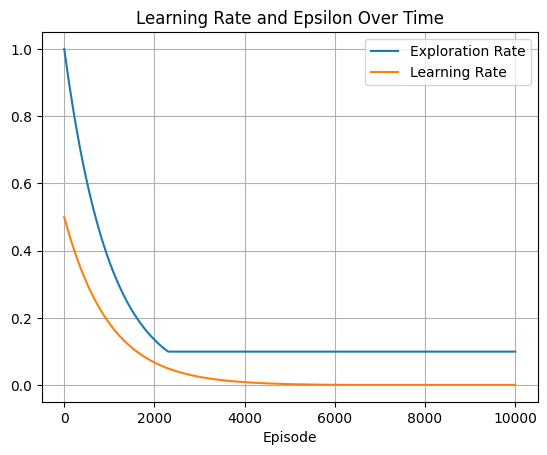

In [ ]:
plt.figure()
plt.title('Reward per Episode')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.plot(np.arange(1, episodes + 1), reward_per_episode)

plot_mean_rewards = []
samples = 20
for i in range(samples):
    cut = int(episodes / samples)
    start = cut * i
    end = cut * (i + 1)
    mean_reward = np.mean(mean_rewards[start:end])
    plot_mean_rewards.append(mean_reward)

plt.figure()
plt.plot(range(1, samples+1), plot_mean_rewards, marker='o')
plt.xlabel(f'Segments of Epochs (x {cut})')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Rewards per Segment of Epochs')
plt.xticks(range(1, samples+1))
plt.grid(True)
plt.show()

plt.figure()
plt.title('Learning Rate and Epsilon Over Time')
plt.xlabel("Episode")
plt.grid(True)
plt.plot(np.arange(1, episodes + 1), epsilon_vals, label='Exploration Rate')
plt.plot(np.arange(1, episodes + 1), alpha_vals, label='Learning Rate')
plt.legend()

plt.show()

### Q-learning algorithm for scenario with γ = 0.9 and N = 2

In [ ]:
# Confirm that our Q-learning algorithm finds the optimal policy given the scenario of the midterm exam
N = 2  # Number of stocks
markov_chains_pr = np.array([[0.5, 0.5, 0.5, 0.5],   # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 1
                             [0.9, 0.1, 0.1, 0.9]])  # Transition probabilities (pHH, pHL, pLH, pLL) of the 2-state Markov chain of stock 2
stock_gains = np.array([[0.1, -0.02],                # Expected gain (rH, rL) of stock 1 depending on the state (H, L) of the Markov chain
                        [0.05, 0.01]])               # Expected gain (rH, rL) of stock 2 depending on the state (H, L) of the Markov chain
transaction_fee = 0.01

gamma = 0.9             # Discount factor
initial_epsilon = 1     # Exploration rate
initial_alpha = 0.5     # Learning rate
min_epsilon = 0.1       # Minimum exploration rate
min_alpha = 0.001       # Minimum learning rate

episodes = 10000        # Number of episodes
episode_length = 100    # Number of steps per episode

env = StockEnvironment(N, markov_chains_pr, stock_gains, transaction_fee)  # Environment initialization
states = env.states
actions = env.actions
trans_pr = env.trans_pr
rewards = env.rewards

# Implement the Q-learning Algorithm and get the measurements and learned policy and value function
learned_policy, q_table, reward_per_episode, epsilon_vals, alpha_vals, mean_rewards = q_learning(states, actions, trans_pr, rewards, gamma, initial_epsilon, initial_alpha, min_epsilon, min_alpha, episodes, episode_length)
learned_value_function = [np.max(q_table[i]) for i in range(len(states))]

print("State Space:", states)
print("Action Space:", actions)
# print("Transition Probabilities:", trans_pr)
# print("Rewards:", rewards)
print("Q-table", q_table)
print("Learned Policy:", learned_policy)
print("Learned Value Function:", learned_value_function)
print("Optimal Policy: {'1HH': 2, '1HL': 1, '1LH': 2, '1LL': 1, '2HH': 2, '2HL': 1, '2LH': 2, '2LL': 1}")
print("Optimal Value Function: [0.42170615 0.41027758 0.42170615 0.41027758 0.43170615 0.40027758 0.43170615 0.40027758]")

  0%|          | 0/10000 [00:00<?, ?it/s]

State Space: ['1HH', '1HL', '1LH', '1LL', '2HH', '2HL', '2LH', '2LL']
Action Space: [1, 2]
Q-table [[0.41626189 0.42277123]
 [0.4055472  0.3684499 ]
 [0.42135689 0.42267235]
 [0.402455   0.36796782]
 [0.4067165  0.43229204]
 [0.39633196 0.37773519]
 [0.40937844 0.43254987]
 [0.39968376 0.37818147]]
Learned Policy: {'1HH': 2, '1HL': 1, '1LH': 2, '1LL': 1, '2HH': 2, '2HL': 1, '2LH': 2, '2LL': 1}
Learned Value Function: [0.42277123442491266, 0.4055472047377595, 0.4226723511966652, 0.40245500066668327, 0.43229204180539277, 0.3963319567718741, 0.4325498679040894, 0.39968375741371553]
Optimal Policy: {'1HH': 2, '1HL': 1, '1LH': 2, '1LL': 1, '2HH': 2, '2HL': 1, '2LH': 2, '2LL': 1}
Optimal Value Function: [0.42170615 0.41027758 0.42170615 0.41027758 0.43170615 0.40027758 0.43170615 0.40027758]


## Task 2

### We used the functions for the generation of uniformally distributed rewards and the transition probabilities as in phase 1

In [ ]:
def get_rewards_uniformally(n):
    result = []
    for i in range(n):
        value1 = random.uniform(-0.02, 0.1)
        value2 = random.uniform(-0.02, 0.1)
        if value1>value2:
            result.append([value1, value2])
        else:
            result.append([value2, value1])

    return np.array(result)

def get_markov_chains_pr(n):
    result = []
    for i in range(n):
        if i%2==0:
            result.append([0.9, 0.1, 0.1, 0.9])
        else:
            result.append([0.5, 0.5, 0.5, 0.5])

    return np.array(result)

### Q-learning algorithm for scenario with γ = 0.9 and N = 3

In [ ]:
N = 3

markov_chains_pr = get_markov_chains_pr(N)
stock_gains = get_rewards_uniformally(N)
print(markov_chains_pr)
print(stock_gains)

transaction_fee = 0.01

gamma = 0.9             # Discount factor
initial_epsilon = 1     # Exploration rate
initial_alpha = 0.5     # Learning rate
min_epsilon = 0.1       # Minimum exploration rate
min_alpha = 0.001       # Minimum learning rate

episodes = 10000        # Number of episodes
episode_length = 100    # Number of steps per episode

env = StockEnvironment(N, markov_chains_pr, stock_gains, transaction_fee)  # Environment initialization
states = env.states
actions = env.actions
trans_pr = env.trans_pr
rewards = env.rewards

# Implement the Q-learning Algorithm and get the measurements and learned policy and value function
learned_policy, q_table, reward_per_episode, epsilon_vals, alpha_vals, mean_rewards = q_learning(states, actions, trans_pr, rewards, gamma, initial_epsilon, initial_alpha, min_epsilon, min_alpha, episodes, episode_length)
learned_value_function = [np.max(q_table[i]) for i in range(len(states))]

print("State Space:", states)
print("Action Space:", actions)
# print("Transition Probabilities:", trans_pr)
# print("Rewards:", rewards)
print("Q-table", q_table)


[[0.9 0.1 0.1 0.9]
 [0.5 0.5 0.5 0.5]
 [0.9 0.1 0.1 0.9]]
[[ 0.07227488 -0.00352165]
 [ 0.01887344  0.00732972]
 [ 0.05735289  0.04364188]]


  0%|          | 0/10000 [00:00<?, ?it/s]

State Space: ['1HHH', '1HHL', '1HLH', '1HLL', '1LHH', '1LHL', '1LLH', '1LLL', '2HHH', '2HHL', '2HLH', '2HLL', '2LHH', '2LHL', '2LLH', '2LLL', '3HHH', '3HHL', '3HLH', '3HLL', '3LHH', '3LHL', '3LLH', '3LLL']
Action Space: [1, 2, 3]
Q-table [[0.59405214 0.52433533 0.56964247]
 [0.58806849 0.51992626 0.55231242]
 [0.59468546 0.52425932 0.56970888]
 [0.58731447 0.51958504 0.55223152]
 [0.49741101 0.49590141 0.5482656 ]
 [0.47118482 0.47435915 0.51596835]
 [0.4982519  0.49545441 0.54839602]
 [0.47642502 0.47301055 0.51587317]
 [0.58488008 0.52985928 0.5639172 ]
 [0.58036254 0.52825318 0.54734301]
 [0.58580249 0.53455946 0.56383188]
 [0.57900509 0.52935956 0.54812963]
 [0.48597416 0.49950369 0.54840338]
 [0.47261756 0.48151015 0.5159831 ]
 [0.48728419 0.50475969 0.5483024 ]
 [0.46973901 0.48276011 0.51479282]
 [0.58520223 0.52412907 0.57746632]
 [0.57825267 0.52110756 0.55977149]
 [0.58613855 0.52254244 0.57719337]
 [0.57822078 0.51910306 0.56045138]
 [0.48769948 0.49632666 0.5580719 ]
 [0.46

In [ ]:
# [[0.9 0.1 0.1 0.9]
#  [0.5 0.5 0.5 0.5]
#  [0.9 0.1 0.1 0.9]]

# [[ 0.07227488 -0.00352165]
#  [ 0.01887344  0.00732972]
#  [ 0.05735289  0.04364188]]

print("Learned Policy:", learned_policy)
print("Learned Value Function:", learned_value_function)
print("Optimal Policy: {'1HHH': 1, '1HHL': 1, '1HLH': 1, '1HLL': 1, '1LHH': 3, '1LHL': 3, '1LLH': 3, '1LLL': 3, '2HHH': 1, '2HHL': 1, '2HLH': 1, '2HLL': 1, '2LHH': 3, '2LHL': 3, '2LLH': 3, '2LLL': 3, '3HHH': 1, '3HHL': 1, '3HLH': 1, '3HLL': 1, '3LHH': 3, '3LHL': 3, '3LLH': 3, '3LLL': 3}")
print("Optimal Value Function: [0.59563359 0.58898135 0.59563359 0.58898135 0.54786193 0.51533986 0.54786193 0.51533986 0.58563359 0.57898135 0.58563359 0.57898135 0.54786193 0.51533986 0.54786193 0.51533986 0.58563359 0.57898135 0.58563359 0.57898135 0.55786193 0.52533986 0.55786193 0.52533986]")

value_counts = Counter(learned_policy.values())
print("Number of times each action appears in the policy generated by the Q-learning algorithm:", value_counts)
print("Number of times each action appears in the optimal policy generated by the PI algorithm: Counter({1: 12, 3: 12})")


Learned Policy: {'1HHH': 1, '1HHL': 1, '1HLH': 1, '1HLL': 1, '1LHH': 3, '1LHL': 3, '1LLH': 3, '1LLL': 3, '2HHH': 1, '2HHL': 1, '2HLH': 1, '2HLL': 1, '2LHH': 3, '2LHL': 3, '2LLH': 3, '2LLL': 3, '3HHH': 1, '3HHL': 1, '3HLH': 1, '3HLL': 1, '3LHH': 3, '3LHL': 3, '3LLH': 3, '3LLL': 3}
Learned Value Function: [0.5940521435304289, 0.5880684936174249, 0.5946854645822982, 0.5873144699248858, 0.5482655960486997, 0.5159683492227166, 0.5483960224460663, 0.5158731697994701, 0.5848800812286512, 0.5803625432444919, 0.5858024902659212, 0.5790050884832421, 0.5484033807772948, 0.5159830978139397, 0.5483024049704536, 0.5147928173099727, 0.5852022278900595, 0.5782526748321488, 0.5861385529966107, 0.5782207800117461, 0.5580719039103473, 0.5261907727303177, 0.557709220016166, 0.525152994795299]
Optimal Policy: {'1HHH': 1, '1HHL': 1, '1HLH': 1, '1HLL': 1, '1LHH': 3, '1LHL': 3, '1LLH': 3, '1LLL': 3, '2HHH': 1, '2HHL': 1, '2HLH': 1, '2HLL': 1, '2LHH': 3, '2LHL': 3, '2LLH': 3, '2LLL': 3, '3HHH': 1, '3HHL': 1, '

### Scenario that is large enough for tabular Q-learning to converge slowly, but still within reasonable time (1 hour)

In [ ]:
N = 8

# markov_chains_pr = get_markov_chains_pr(N)
# stock_gains = get_rewards_uniformally(N)
# print(markov_chains_pr)
# print(stock_gains)

markov_chains_pr = np.array([[0.9, 0.1, 0.1, 0.9],
                            [0.5, 0.5, 0.5, 0.5],
                            [0.9, 0.1, 0.1, 0.9],
                            [0.5, 0.5, 0.5, 0.5],
                            [0.9, 0.1, 0.1, 0.9],
                            [0.5, 0.5, 0.5, 0.5],
                            [0.9, 0.1, 0.1, 0.9],
                            [0.5, 0.5, 0.5, 0.5]])

stock_gains = np.array([[ 0.06104255,  0.03158808],
                        [ 0.083696,    0.00330492],
                        [ 0.06152034,  0.04536063],
                        [ 0.08008902, -0.00578924],
                        [ 0.0932866,   0.04249886],
                        # [ 0.09125022,  0.08494483],
                        [ 0.09125022,  0.045],
                        [ 0.06502391,  0.05328662],
                        [ 0.08333102,  0.04500553]])

transaction_fee = 0.01

gamma = 0.9             # Discount factor
initial_epsilon = 1     # Exploration rate
initial_alpha = 0.5     # Learning rate
min_epsilon = 0.1       # Minimum exploration rate
min_alpha = 0.001       # Minimum learning rate

episodes = 10000        # Number of episodes
episode_length = 1000   # Number of steps per episode

env = StockEnvironment(N, markov_chains_pr, stock_gains, transaction_fee)  # Environment initialization
states = env.states
actions = env.actions
trans_pr = env.trans_pr
rewards = env.rewards

# Implement the Q-learning Algorithm and get the measurements and learned policy and value function
learned_policy, q_table, reward_per_episode, epsilon_vals, alpha_vals, mean_rewards = q_learning(states, actions, trans_pr, rewards, gamma, initial_epsilon, initial_alpha, min_epsilon, min_alpha, episodes, episode_length)
learned_value_function = [np.max(q_table[i]) for i in range(len(states))]

print("State Space:", states)
print("Action Space:", actions)
# print("Transition Probabilities:", trans_pr)
# print("Rewards:", rewards)
print("Q-table", q_table)
print("Learned Policy:", learned_policy)
print("Learned Value Function:", learned_value_function)


  0%|          | 0/10000 [00:00<?, ?it/s]

State Space: ['1HHHHHHHH', '1HHHHHHHL', '1HHHHHHLH', '1HHHHHHLL', '1HHHHHLHH', '1HHHHHLHL', '1HHHHHLLH', '1HHHHHLLL', '1HHHHLHHH', '1HHHHLHHL', '1HHHHLHLH', '1HHHHLHLL', '1HHHHLLHH', '1HHHHLLHL', '1HHHHLLLH', '1HHHHLLLL', '1HHHLHHHH', '1HHHLHHHL', '1HHHLHHLH', '1HHHLHHLL', '1HHHLHLHH', '1HHHLHLHL', '1HHHLHLLH', '1HHHLHLLL', '1HHHLLHHH', '1HHHLLHHL', '1HHHLLHLH', '1HHHLLHLL', '1HHHLLLHH', '1HHHLLLHL', '1HHHLLLLH', '1HHHLLLLL', '1HHLHHHHH', '1HHLHHHHL', '1HHLHHHLH', '1HHLHHHLL', '1HHLHHLHH', '1HHLHHLHL', '1HHLHHLLH', '1HHLHHLLL', '1HHLHLHHH', '1HHLHLHHL', '1HHLHLHLH', '1HHLHLHLL', '1HHLHLLHH', '1HHLHLLHL', '1HHLHLLLH', '1HHLHLLLL', '1HHLLHHHH', '1HHLLHHHL', '1HHLLHHLH', '1HHLLHHLL', '1HHLLHLHH', '1HHLLHLHL', '1HHLLHLLH', '1HHLLHLLL', '1HHLLLHHH', '1HHLLLHHL', '1HHLLLHLH', '1HHLLLHLL', '1HHLLLLHH', '1HHLLLLHL', '1HHLLLLLH', '1HHLLLLLL', '1HLHHHHHH', '1HLHHHHHL', '1HLHHHHLH', '1HLHHHHLL', '1HLHHHLHH', '1HLHHHLHL', '1HLHHHLLH', '1HLHHHLLL', '1HLHHLHHH', '1HLHHLHHL', '1HLHHLHLH', '1HLHHLHLL'

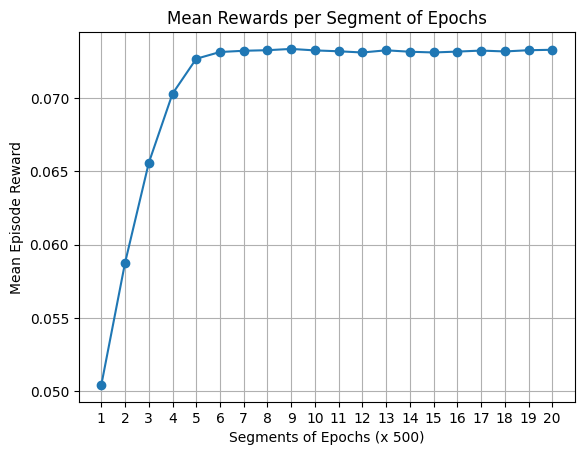

In [ ]:
plot_mean_rewards = []
samples = 20
for i in range(samples):
    cut = int(episodes / samples)
    start = cut * i
    end = cut * (i + 1)
    mean_reward = np.mean(mean_rewards[start:end])
    plot_mean_rewards.append(mean_reward)

plt.figure()
plt.plot(range(1, samples+1), plot_mean_rewards, marker='o')
plt.xlabel(f'Segments of Epochs (x {cut})')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Rewards per Segment of Epochs')
plt.xticks(range(1, samples+1))
plt.grid(True)
plt.show()

Number of times each action appears in the policy generated by the Q-learning algorithm: Counter({5: 960, 6: 919, 7: 80, 8: 58, 3: 19, 1: 12})


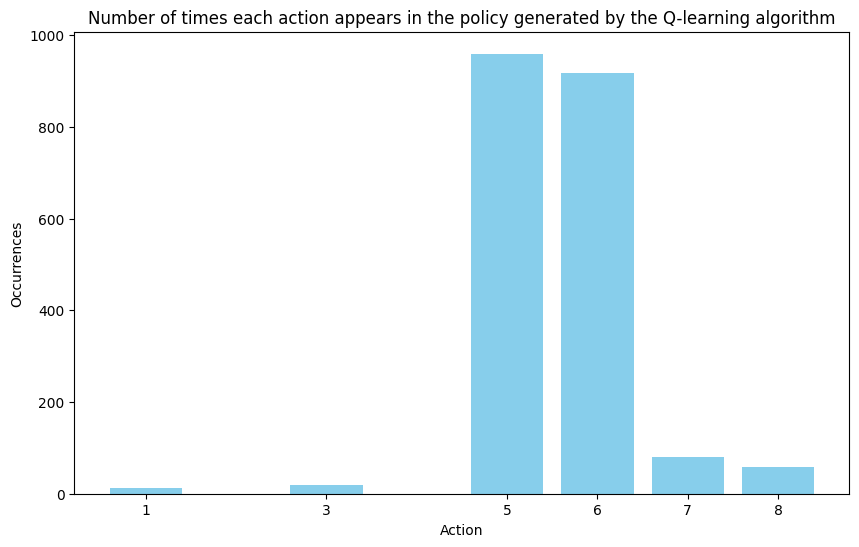

In [ ]:
value_counts = Counter(learned_policy.values())
print("Number of times each action appears in the policy generated by the Q-learning algorithm:", value_counts)

values = list(value_counts.keys())
occurrences = list(value_counts.values())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(values, occurrences, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Occurrences')
plt.title(f'Number of times each action appears in the policy generated by the Q-learning algorithm')
plt.xticks(values)
plt.show()


Number of times each action appears in the policy generated by the Q-learning algorithm: Counter({6: 2031, 5: 17})
Number of times each action appears in the optimal policy generated by the PI algorithm: Counter({6: 1920, 5: 128})


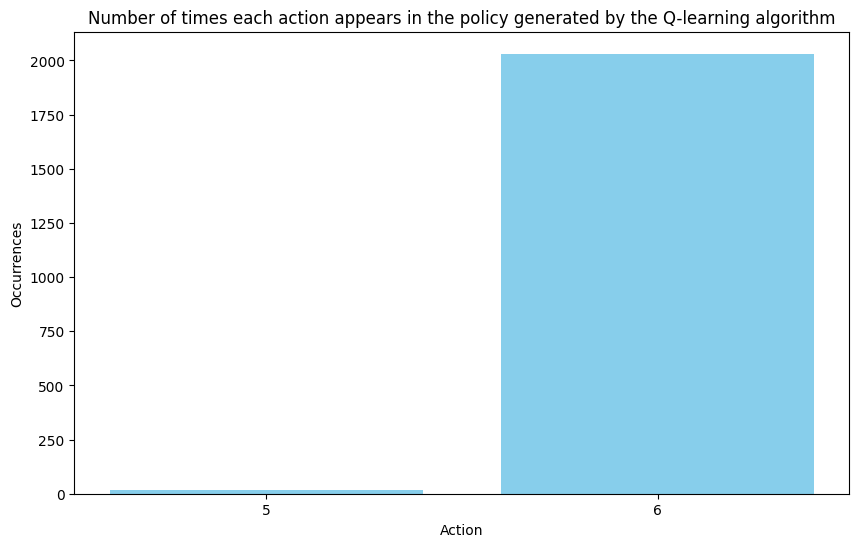

In [ ]:
# Old one before changes
# markov_chains_pr = np.array([[0.9, 0.1, 0.1, 0.9],
#                             [0.5, 0.5, 0.5, 0.5],
#                             [0.9, 0.1, 0.1, 0.9],
#                             [0.5, 0.5, 0.5, 0.5],
#                             [0.9, 0.1, 0.1, 0.9],
#                             [0.5, 0.5, 0.5, 0.5],
#                             [0.9, 0.1, 0.1, 0.9],
#                             [0.5, 0.5, 0.5, 0.5]])

# stock_gains = np.array([[ 0.06104255,  0.03158808],
#                         [ 0.083696,    0.00330492],
#                         [ 0.06152034,  0.04536063],
#                         [ 0.08008902, -0.00578924],
#                         [ 0.0932866,   0.04249886],
#                         [ 0.09125022,  0.08494483],
#                         [ 0.06502391,  0.05328662],
#                         [ 0.08333102,  0.04500553]])

value_counts = Counter(learned_policy.values())
print("Number of times each action appears in the policy generated by the Q-learning algorithm:", value_counts)
print("Number of times each action appears in the optimal policy generated by the PI algorithm: Counter({6: 1920, 5: 128})")

# For episodes = 10000, episode_length = 100:
# Number of times each action appears in the policy generated by the Q-learning algorithm: Counter({6: 974, 5: 392, 7: 192, 8: 189, 1: 107, 3: 90, 2: 63, 4: 41})

# For episodes = 10000, episode_length = 500:
# Number of times each action appears in the policy generated by the Q-learning algorithm: Counter({6: 1587, 5: 309, 8: 68, 7: 30, 3: 24, 1: 18, 2: 7, 4: 5})

# For episodes = 10000, episode_length = 1000:
# Number of times each action appears in the policy generated by the Q-learning algorithm: Counter({6: 2031, 5: 17})

values = list(value_counts.keys())
occurrences = list(value_counts.values())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(values, occurrences, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Occurrences')
plt.title(f'Number of times each action appears in the policy generated by the Q-learning algorithm')
plt.xticks(values)
plt.show()
